**Transfer Learning for Computer Vision**
how to train a convolutional neural network for image classification using transfer learning

ImageNet, which contains 1.2 million images with 1000 categories

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data

In [ ]:
from google.colab import drive
from tensorflow import keras

In [ ]:
drive.mount._DEBUG = True
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/'

In [ ]:
file = ''.join(root_path+'Intel_Image_Classification_train.zip')
file

'gdrive/My Drive/Intel_Image_Classification_train.zip'

In [ ]:
!mkdir datas
import zipfile
with zipfile.ZipFile(file,"r") as zip_ref:
    zip_ref.extractall("datas")

In [ ]:
path = '/content/datas/Intel_Image_Classification_train'
import os
from skimage.io import imread
for subdir in os.listdir(path):
    print(subdir)
    current_path = os.path.join(path, subdir)
    nb = 0
    for file in os.listdir(current_path):
        if (file[-3:] in {'bmp', 'gif'}):
            print(os.path.join(current_path, file))
            os.remove(os.path.join(current_path, file))

train
val


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/datas/Intel_Image_Classification_train'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('classes',class_names)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Get cpu or gpu device for training.


classes ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Visualize a few images

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5526 Acc: 0.8042
val Loss: 0.2373 Acc: 0.9163

Epoch 1/24
----------
train Loss: 0.3257 Acc: 0.8829
val Loss: 0.1970 Acc: 0.9260

Epoch 2/24
----------
train Loss: 0.2961 Acc: 0.8900
val Loss: 0.1856 Acc: 0.9327

Epoch 3/24
----------
train Loss: 0.2852 Acc: 0.8953
val Loss: 0.1824 Acc: 0.9327

Epoch 4/24
----------
train Loss: 0.2666 Acc: 0.9039
val Loss: 0.1942 Acc: 0.9287

Epoch 5/24
----------
train Loss: 0.2614 Acc: 0.9032
val Loss: 0.1705 Acc: 0.9383

Epoch 6/24
----------
train Loss: 0.2491 Acc: 0.9081
val Loss: 0.1654 Acc: 0.9380

Epoch 7/24
----------
train Loss: 0.2285 Acc: 0.9162
val Loss: 0.1661 Acc: 0.9390

Epoch 8/24
----------
train Loss: 0.2287 Acc: 0.9151
val Loss: 0.1643 Acc: 0.9413

Epoch 9/24
----------
train Loss: 0.2228 Acc: 0.9173
val Loss: 0.1621 Acc: 0.9393

Epoch 10/24
----------
train Loss: 0.2234 Acc: 0.9171
val Loss: 0.1639 Acc: 0.9373

Epoch 11/24
----------
train Loss: 0.2247 Acc: 0.9172
val Loss: 0.1621 Acc: 0.9427

Ep

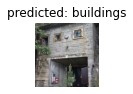

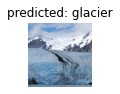

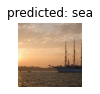

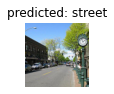

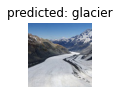

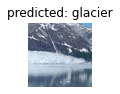

In [ ]:
visualize_model(model_ft)

In [ ]:
import copy
import pickle

saved_trainer = copy.deepcopy(model_ft)
with open(r"resnet18_model.pkl", "wb") as output_file:
    pickle.dump(saved_trainer, output_file)

Prediction

In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
   # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
from torch.autograd import Variable
from PIL import Image

# An instance of your model.
img_pil = Image.open('gdrive/MyDrive/places/google/forest.jpeg')
#img_pil.show()
img_tensor = preprocess(img_pil).float()
img_tensor = img_tensor.unsqueeze_(0)
img_tensor = img_tensor.cuda()

fc_out = model_ft(Variable(img_tensor))

output = fc_out.cpu().detach().numpy()
print(class_names[output.argmax()])

forest


In [ ]:
output

array([[-3.2038426 ,  9.975794  , -0.23379782, -2.189794  , -0.875675  ,
        -3.3254561 ]], dtype=float32)

In [ ]:
print('classes',class_names)

classes ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
with open('resnet18_model.pkl','rb') as file:
    resnet18_model = pickle.load(file)

In [ ]:
fc_out = resnet18_model(Variable(img_tensor))

output = fc_out.cpu().detach().numpy()
print(class_names[output.argmax()])

forest


In [ ]:
PATH = "state_dict_model.pt"
model_ft_save = torch.save(model_ft.state_dict,PATH)

In [ ]:
model_ft.save('model_ft.h5')

In [ ]:
best_model_save = copy.deepcopy(model_ft.state_dict())

In [ ]:
model_ft.load_state_dict(best_model_save)

<All keys matched successfully>

In [ ]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
fc_out = model_ft_save(Variable(img_tensor))

output = fc_out.cpu().detach().numpy()
print(class_names[output.argmax()])

ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

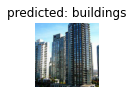

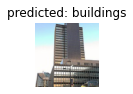

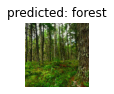

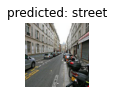

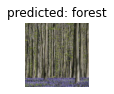

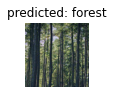

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()